In [28]:
import numpy as np # linear algebra
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
data = pd.read_csv("ner_dataset.csv",encoding = 'latin1')
data = data.fillna(method = 'ffill')
data.head()
# data.shape

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [30]:
data.nunique()

Sentence #    47959
Word          35178
POS              42
Tag              17
dtype: int64

In [31]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)
num_words

35179

In [32]:
words_tag = list(set(data["Tag"].values))
# words_tag.append("ENDPAD")
num_words_tag = len(words_tag)
num_words_tag

17

In [33]:
num_words,num_words_tag
group = data.groupby(data["Sentence #"])

In [34]:
class Get_sentence(object):
    def __init__(self,data):
        self.n_sent=1
        self.data = data
        agg_func = lambda s:[(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),
                                                     s["POS"].values.tolist(),
                                                     s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [35]:
getter = Get_sentence(data)
sentence = getter.sentences
sentence[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [36]:
word_idx = {w : i+1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(words_tag)}

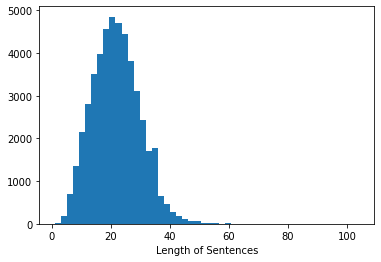

In [37]:
plt.hist([len(s) for s in sentence],bins= 50)
plt.xlabel("Length of Sentences")
plt.show()

In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50
X = [[word_idx[w[0]] for w in s] for s in sentence]
X = pad_sequences(maxlen = max_len,sequences = X,padding = 'post',value = num_words-1)
y = [[tag_idx[w[2]] for w in s] for s in sentence]
y = pad_sequences(maxlen = max_len,sequences = y,padding = 'post',value = tag_idx['O'])
y = [to_categorical(i,num_classes = num_words_tag) for i in  y]

In [39]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state=1)

In [40]:
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional

In [45]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim = num_words,output_dim = max_len,input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100,return_sequences = True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_words_tag,activation = 'softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
# from livelossplot import PlotLossesKeras
early_stopping = EarlyStopping(monitor = 'val_accuracy',patience =2,verbose = 0,mode = 'max',restore_best_weights = False)
callbacks = [early_stopping]

history = model.fit(
    x_train,np.array(y_train),
    validation_split =0.2,
    batch_size = 64,
    epochs = 3,
    verbose =1
)

Epoch 1/3
540/540 [==============================] - 148s 274ms/step - loss: 0.2686 - accuracy: 0.9428 - val_loss: 0.1184 - val_accuracy: 0.9665
Epoch 2/3
540/540 [==============================] - 147s 272ms/step - loss: 0.0775 - accuracy: 0.9783 - val_loss: 0.0598 - val_accuracy: 0.9825
Epoch 3/3
540/540 [==============================] - 146s 271ms/step - loss: 0.0479 - accuracy: 0.9859 - val_loss: 0.0519 - val_accuracy: 0.9843


In [48]:
model.evaluate(x_test,np.array(y_test))

150/150 [==============================] - 4s 26ms/step - loss: 0.0539 - accuracy: 0.9842


[0.05392305180430412, 0.9841659665107727]

In [49]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
# print(np.shape(p))
# print(p)
p = np.argmax(p, axis=-1)


y_true = np.argmax(np.array(y_test), axis=-1)[i]

print("{:15}{:5}\t{}\n".format("Word", "True", "Pred"))
print("-"*30)

for (w, t, pred) in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], words_tag[t], words_tag[pred]))

Word           True 	Pred

------------------------------
Sri            B-per	B-per
Lankan         I-per	I-per
officials      O	O
say            O	O
suspected      O	O
Tamil          B-org	B-org
Tiger          I-org	I-org
rebels         O	O
have           O	O
detonated      O	O
a              O	O
mine           O	O
in             O	O
northern       O	O
Sri            B-geo	B-geo
Lanka          I-geo	I-geo
,              O	O
killing        O	O
two            O	O
sailors        O	O
and            O	O
wounding       O	O
another        O	O
.              O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Zeal           O	O
Z